# DIRAC on Human Glioblastoma — Vertical Tutorial

> Goal: Run DIRAC on a **real Human Glioblastoma** spatial multi-omics sample (RNA + Protein/ADT), produce a joint embedding, cluster with Mclust, visualize spatial maps, and save all outputs (H5AD/CSV/PDF) for downstream analysis.  

---

## Table of Contents

1. [Overview](#overview)
2. [Environment & Data](#environment--data)
3. [End-to-End Script (copy/paste)](#end-to-end)
4. [Parameter Notes & Good Defaults](#parameter-notes)
5. [Outputs & File Saving](#outputs)
6. [Reproducibility](#reproducibility)
7. [Troubleshooting & Tips](#troubleshooting)

---
## 1. Overview

- **Data**: Human Glioblastoma with **RNA** and **Protein (ADT)** modalities.  
- **Integration**: DIRAC learns a joint embedding from RNA PCA + ADT expression using a spatial **k-NN** graph.  
- **Clustering**: `mclust` (via R) to obtain discrete domains (here `n_clusters = 9`).  
- **Visualization**: spatial clustering maps (PDF), colored by cluster assignments.  
- **Artifacts**: save AnnData objects, cluster CSV, and figures to a dedicated output folder.

---
## 2. Environment & Data

**Dependencies (minimum)**  
- Python ≥ 3.8  
- `scanpy`, `anndata`, `numpy`, `matplotlib`, `pandas`
- **R** with package **`mclust`** (required for `sd.utils.mclust_R`)  
- **DIRAC** codebase locally available
  If not installed, follow: https://dirac-tutorial.readthedocs.io/en/latest/install.html

**Paths used**  
- `data_path`: `../DIRAC-main/data/Glioblastoma`  
- `data_name`: `Human_Glioblastoma`  
- `out_path`: `./Results`  
- `save_path`: `./Results/Human_Glioblastoma_DIRAC` (auto-created)

**Expected files**  
- `Human_Glioblastoma_RNA.h5ad`  
- `Human_Glioblastoma_Protein.h5ad`

**Download link:**  
- https://drive.google.com/drive/folders/1Q9xVtwlDiUgdCy9BR4BzeR0_9Zlr5asW?usp=drive_link
- or https://www.10xgenomics.com/datasets/gene-and-protein-expression-library-of-human-glioblastoma-cytassist-ffpe-2-standard

---
## 3. End-to-End Script

**At-a-glance map:**  
- 3.1–3.3 = prep & preprocessing  
- 3.4 = build graph  
- 3.5 = DIRAC training (joint embedding)  
- 3.6 = write embedding  
- 3.7 = clustering + spatial plot
- 3.8 = (Optional) Cross-omics mixing check — UMAP on the joint embedding 
- 3.8 = save outputs (H5AD/CSV/PDF)

It uses GPU if available; otherwise set `use_gpu=False`.

---
### 3.1 Imports, fonts, paths, and seed

In [1]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import anndata
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import sodirac as sd
sd.utils.seed_torch(seed=6)

data_path = "../DIRAC-main/data/Glioblastoma"
data_name = "Human_Glioblastoma"
methods = "DIRAC"
out_path = "./Results"
n_clusters = 9
save_path = os.path.join(out_path, f"{data_name}_{methods}")
if not os.path.exists(save_path):
	os.makedirs(save_path)

---
### 3.2 Load RNA/Protein and align cell order

In [2]:
adata_RNA = sc.read(os.path.join(data_path,f"{data_name}_RNA.h5ad"))
adata_RNA.raw = adata_RNA
adata_RNA.var_names_make_unique()
adata_Protein = sc.read(os.path.join(data_path,f"{data_name}_Protein.h5ad"))
adata_Protein.raw = adata_Protein
adata_Protein = adata_Protein[adata_RNA.obs_names]

# adata_RNA = adata_RNA.copy()
adata_RNA.obsm["spatial"] = adata_RNA.obsm["spatial"].astype(float)
# adata_Protein = adata_Protein.copy() 
adata_Protein.obsm["spatial"] = adata_Protein.obsm["spatial"].astype(float)

/home/project/11003054/changxu/Conda_envs/dirac-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/project/11003054/changxu/Conda_envs/dirac-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_3355960/3436773580.py:11: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata_Protein.obsm["spatial"] = adata_Protein.obsm["spatial"].astype(float)


---
### 3.3 Preprocess (RNA: filter/HVG/PCA; ADT: normalize/log/scale)

In [3]:
######### Data processing
sc.pp.filter_genes(adata_RNA, min_cells=3)
sc.pp.normalize_total(adata_RNA)
sc.pp.log1p(adata_RNA)
sc.pp.highly_variable_genes(adata_RNA, n_top_genes=2000)
sc.pp.scale(adata_RNA)
sc.tl.pca(adata_RNA, n_comps=100)

sc.pp.normalize_total(adata_Protein)
sc.pp.log1p(adata_Protein)
sc.pp.scale(adata_Protein)

---
### 3.4 Build the spatial k-NN graph

In [4]:
edge_index = sd.utils.get_single_edge_index(adata_RNA.obsm["spatial"], n_neighbors = 8)

Average neighbors per node (directed): 8.00 (edges=46048, nodes=5756)


---
### 3.5 Configure and train DIRAC

In [5]:
dirac = sd.main.integrate_app(save_path = save_path, use_gpu = True, subgraph = False)
samples = dirac._get_data(dataset_list = [adata_RNA.obsm['X_pca'], adata_Protein.X], edge_index = edge_index)
models = dirac._get_model(samples, opt_GNN = "GAT") 
data_z, combine_recon = dirac._train_dirac_integrate(samples = samples, models = models, scale_loss = 0.04, epochs = 300)

Found 2 unique domains.


DIRAC integrate..: 100%|█| 300/300 [0


---
### 3.6 Write back the joint embedding

In [6]:
adata_RNA.obsm["DIRAC_embed"] = combine_recon
adata_Protein.obsm["DIRAC_embed"] = combine_recon

---
### 3.7 Cluster (MCLUST via R) and make a spatial plot

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


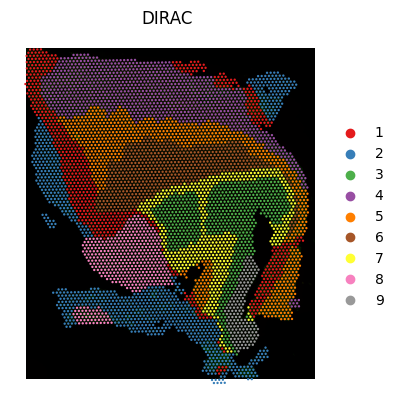

In [7]:
# Optional: palette for up to ~30 clusters
colormaps = ["#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "#A65628", "#FFFF33", "#F781BF", "#999999",
        "#E5D8BD", "#B3CDE3", "#CCEBC5", "#FED9A6", "#FBB4AE", "#8DD3C7", "#BEBADA", "#80B1D3", "#B3DE69", "#FCCDE5",
        "#BC80BD", "#FFED6F", "#8DA0CB", "#E78AC3", "#E5C494", "#CCCCCC", "#FB9A99", "#E31A1C", "#CAB2D6", "#6A3D9A", "#B15928"]

sd.utils.mclust_R(adata=adata_RNA, num_cluster = n_clusters, used_obsm="DIRAC_embed",key_added="DIRAC")
sc.pl.spatial(adata_RNA, color=["DIRAC"], palette = colormaps, frameon=False, spot_size=200, show=False)
plt.savefig(os.path.join(save_path, f"{data_name}_{methods}_spatial.pdf"), bbox_inches='tight', dpi = 300)

---
### 3.8 (Optional) Cross-omics mixing check — UMAP on the joint embedding

**What/why:** After clustering the RNA layer, you may want to **verify that RNA and Protein cells are well mixed** in the **shared embedding** (i.e., integration worked). The snippet below:
1) tags each cell with its modality,  
2) builds a combined AnnData from the joint embedding,  
3) runs neighbors/UMAP + Leiden and MCLUST on the embedding,  
4) plots UMAP colored by **Omics**, **embed_mclust**, and **embed_leiden**.
   
> Assumption: `data_z` is the **stacked embedding** returned by DIRAC for all cells in the same order as `dataset_list=[RNA, Protein]`, i.e. `data_z = [RNA_rows; Protein_rows]`. If your method returns a different ordering, reorder `adata.obs` accordingly before concatenation.

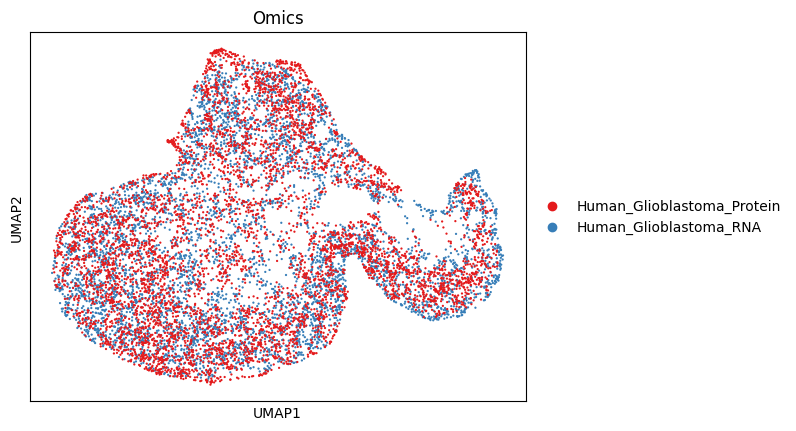

In [8]:
# Label each modality for mixing diagnostics
adata_RNA.obs["Omics"] = data_name + "_RNA"
adata_RNA.obs["Omics"] = adata_RNA.obs["Omics"].astype("category")

adata_Protein.obs["Omics"] = data_name + "_Protein"
adata_Protein.obs["Omics"] = adata_Protein.obs["Omics"].astype("category")

# Build a combined AnnData on top of the joint embedding
# X := data_z so neighbors/UMAP use the learned space
adata = anndata.AnnData(data_z)
adata.obs = pd.concat([adata_RNA.obs, adata_Protein.obs], axis=0)

# Also store the embedding in obsm for methods that expect a named rep
adata.obsm[f"{methods}_embed"] = data_z

# UMAP over the joint space
sc.pp.neighbors(adata, use_rep="X")
sc.tl.umap(adata)

# Visualize modality mixing and clusters in UMAP
sc.pl.umap(adata, color="Omics", palette=colormaps, show=False)
plt.savefig(os.path.join(save_path, f"{data_name}_{methods}_embed_umap.pdf"), bbox_inches="tight", dpi=300)

---
### 3.9 Save all artifacts (H5AD / CSV)

In [9]:
adata_RNA.write(os.path.join(save_path, f"{data_name}_{methods}_RNA.h5ad"), compression="gzip")
adata_Protein.write(os.path.join(save_path, f"{data_name}_{methods}_Protein.h5ad"), compression="gzip")
adata_RNA.obs['DIRAC'].to_csv(os.path.join(save_path, f"{data_name}_{methods}.csv"))

---
## 4. Parameter Notes & Good Defaults

- **n_neighbors (graph)**: 6–12 are common. More neighbors → smoother neighborhoods; fewer → sharper boundaries.  
- **RNA HVGs (`n_top_genes`)**: 2k–3k typical; trial 1–5k for sensitivity.  
- **PCA components**: 50–100 usually sufficient; large tissues can benefit from 100+.  
- **GNN (`opt_GNN`)**: `"GAT"` (attentional, expressive), `"SAGE"` (efficient), `"GCN"` (simple).  
- **n_hiddens / n_outputs**: start at 128 / 64; increase for complex tissues, reduce for memory.  
- **epochs**: 200–400 typical for stable embeddings.  
- **lamb (regularization)**: ↑ if overfitting; ↓ if underfitting.  
- **scale_loss**: balances reconstruction and other terms; small tweaks (0.02–0.06) can help.  
- **n_clusters (MCLUST)**: use prior knowledge or grid-search; Leiden is an alternative if R/mclust is unavailable.  
- **spot_size**: adapt to the platform’s spot diameter for best visual density.

**Optional subgraph mode**  
- For very large samples or limited VRAM: initialize `integrate_app(..., subgraph=True)` and pass `num_parts` in `_get_data(...)` to split the graph.  
- Larger `num_parts` → lower peak memory but more overhead.

---
## 5. Outputs & File Saving

- **Figures**:  
  `Results/Human_Glioblastoma_DIRAC/Human_Glioblastoma_DIRAC_Combined_spatial.pdf`  
- **AnnData**:  
  `Results/Human_Glioblastoma_DIRAC/Human_Glioblastoma_DIRAC_RNA.h5ad`  
  `Results/Human_Glioblastoma_DIRAC/Human_Glioblastoma_DIRAC_Protein.h5ad`  
- **Labels (CSV)**:  
  `Results/Human_Glioblastoma_DIRAC/Human_Glioblastoma_DIRAC.csv` (column = `DIRAC`)

**What’s inside**  
- `obsm["DIRAC_embed"]`: shared embedding for downstream neighbors/UMAP.  
- `obs["DIRAC"]`: MCLUST cluster labels (strings).  
- `uns` often contains plotting metadata after `scanpy` calls.



---
## 6. Reproducibility

- Set deterministic seeds: `sd.utils.seed_torch(seed=6)` (already in the script).  
- Minor non-determinism may persist on GPU due to cuDNN; results should be qualitatively stable.  

---
## 7. Troubleshooting & Tips

- **R/mclust not found**: install R + `mclust` and ensure `Rscript` is on PATH; otherwise switch to Leiden for clustering.  
- **Memory issues**: reduce `n_hiddens` / `n_outputs`, or enable subgraph mode and set `num_parts`.  
- **Flat clusters**: raise `epochs`, lower `lr` (if exposed), or increase `n_neighbors`.  
- **Noisy boundaries**: slightly increase `n_neighbors` or use a radius graph tuned to platform resolution.  
- **Mismatched cells between RNA/Protein**: verify `obs_names` alignment step and check for missing barcodes.  
- **Font issues in PDF**: `mpl.rcParams['pdf.fonttype']=42` ensures editable text in vector editors.

---

**Ready to go:** Copy the **End-to-End Script** into your notebook, adjust paths if needed, and run. The tutorial above explains each choice so users can reproduce and extend your results confidently.